<a href="https://www.kaggle.com/code/aisuko/eda-on-cmfoadb?scriptVersionId=193037602" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## High Dimensionality

Each unique word in the dataset becomes a dimension. With a limited number of questions, you'll likely have a very sparse and high-dimensional space, making it difficult for algorithms to find meaningful clusters.

## Semantic Similarity
Clustering based on raw word occurrences might not capture the underlying meaning of the questions. For example, "What chemistry does..." and "What metabolites does..." are semantically very similar but would be treated as distinct based on word overlap alone.

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# Load dataset

In [4]:
import pandas as pd

df=pd.read_excel('/kaggle/input/cmfoadb-common-queries/CMFoADB 2024 quries.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Questions  112 non-null    object
dtypes: object(1)
memory usage: 1.0+ KB


In [5]:
df_dict=df.to_dict()

In [6]:
print(df_dict.get("Questions")[0])

What chemistry does  specific plant produce?


# Text preprocessing and feature engineering

## Tokenization

In [7]:
tokens=[ nltk.word_tokenize (ques) for ques in df_dict.get('Questions').values()]

In [8]:
len(tokens)

112

## Stop word removal

In [9]:
stop_words=set(stopwords.words('english'))
filtered_tokens=[[word for word in token_list if word.lower() not in stop_words] for token_list in tokens]
print(len(filtered_tokens))

112


## Stemming

In [10]:
stemmer = PorterStemmer()
stemmed_tokens=[[stemmer.stem(word) for word in token_list] for token_list in filtered_tokens]
print(len(stemmed_tokens))

112


## Lemmatization

In [11]:
lemmatizer = WordNetLemmatizer()
lemmatized_tokens = [[lemmatizer.lemmatize(word) for word in token_list] for token_list in filtered_tokens]
print(len(lemmatized_tokens))

112


## TF-IDF

Calculate Term Frequency-Inverse Document Frequency to weigh the importance of words within each question and across the entire dataset. This helps identify words that are distinctive to particular clusters.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

lemmatized_questions = [' '.join(tokens) for tokens in lemmatized_tokens]

In [13]:
df = pd.DataFrame({'Questions': lemmatized_questions})

In [14]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['Questions'])

In [15]:
dense_matrix = tfidf_matrix.toarray()

In [16]:
feature_names = vectorizer.get_feature_names_out()
print(feature_names)

['across' 'among' 'appear' 'application' 'associated' 'australian' 'based'
 'belong' 'bioactive' 'breakdown' 'ceremonial' 'changed' 'chemical'
 'chemistry' 'class' 'cluster' 'common' 'commonly' 'compare' 'composition'
 'compound' 'considered' 'constituent' 'correlation' 'culinary' 'cultural'
 'culture' 'dataset' 'despite' 'different' 'distribution' 'diverse'
 'diversity' 'ecological' 'effect' 'endangered' 'environmental' 'evolved'
 'example' 'family' 'found' 'genus' 'geographical' 'habitat' 'harmful'
 'health' 'identified' 'identify' 'implication' 'including' 'indigenous'
 'infraclass' 'infraclasses' 'level' 'many' 'medicinal' 'medicine'
 'metabolite' 'modern' 'multiple' 'natural' 'niche' 'non' 'order'
 'overrepresented' 'particularly' 'pattern' 'pharmacological'
 'phytochemical' 'plant' 'poorly' 'potential' 'practice' 'preference'
 'pressure' 'prevalent' 'preventative' 'produce' 'product' 'property'
 'provide' 'purpose' 'region' 'represented' 'research' 'response'
 'scientific' 'secon

# Visualization

We're going to visualize these features.

## Word Clouds

Quickly see the most fequent and important words across all questions.

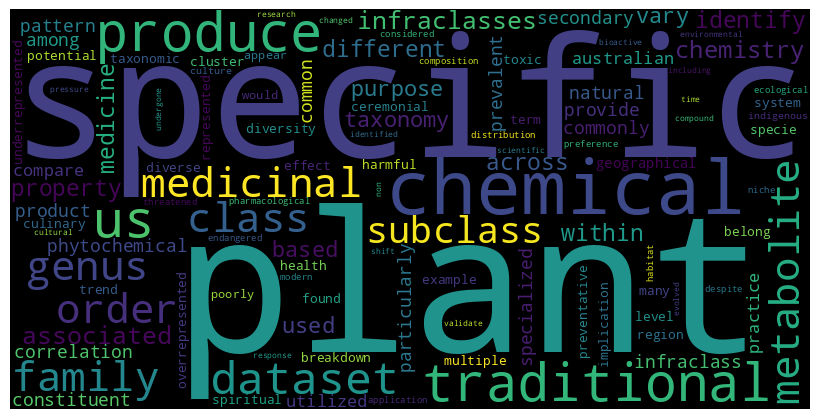

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_scores=tfidf_matrix.sum(axis=0).A1

word_dict=dict(zip(feature_names, word_scores))

wordcloud=WordCloud(width=800, height=400).generate_from_frequencies(word_dict)

plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Feature Importance Plot

Show the top n most important words for each question

/tmp/ipykernel_18/2467323374.py:19: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


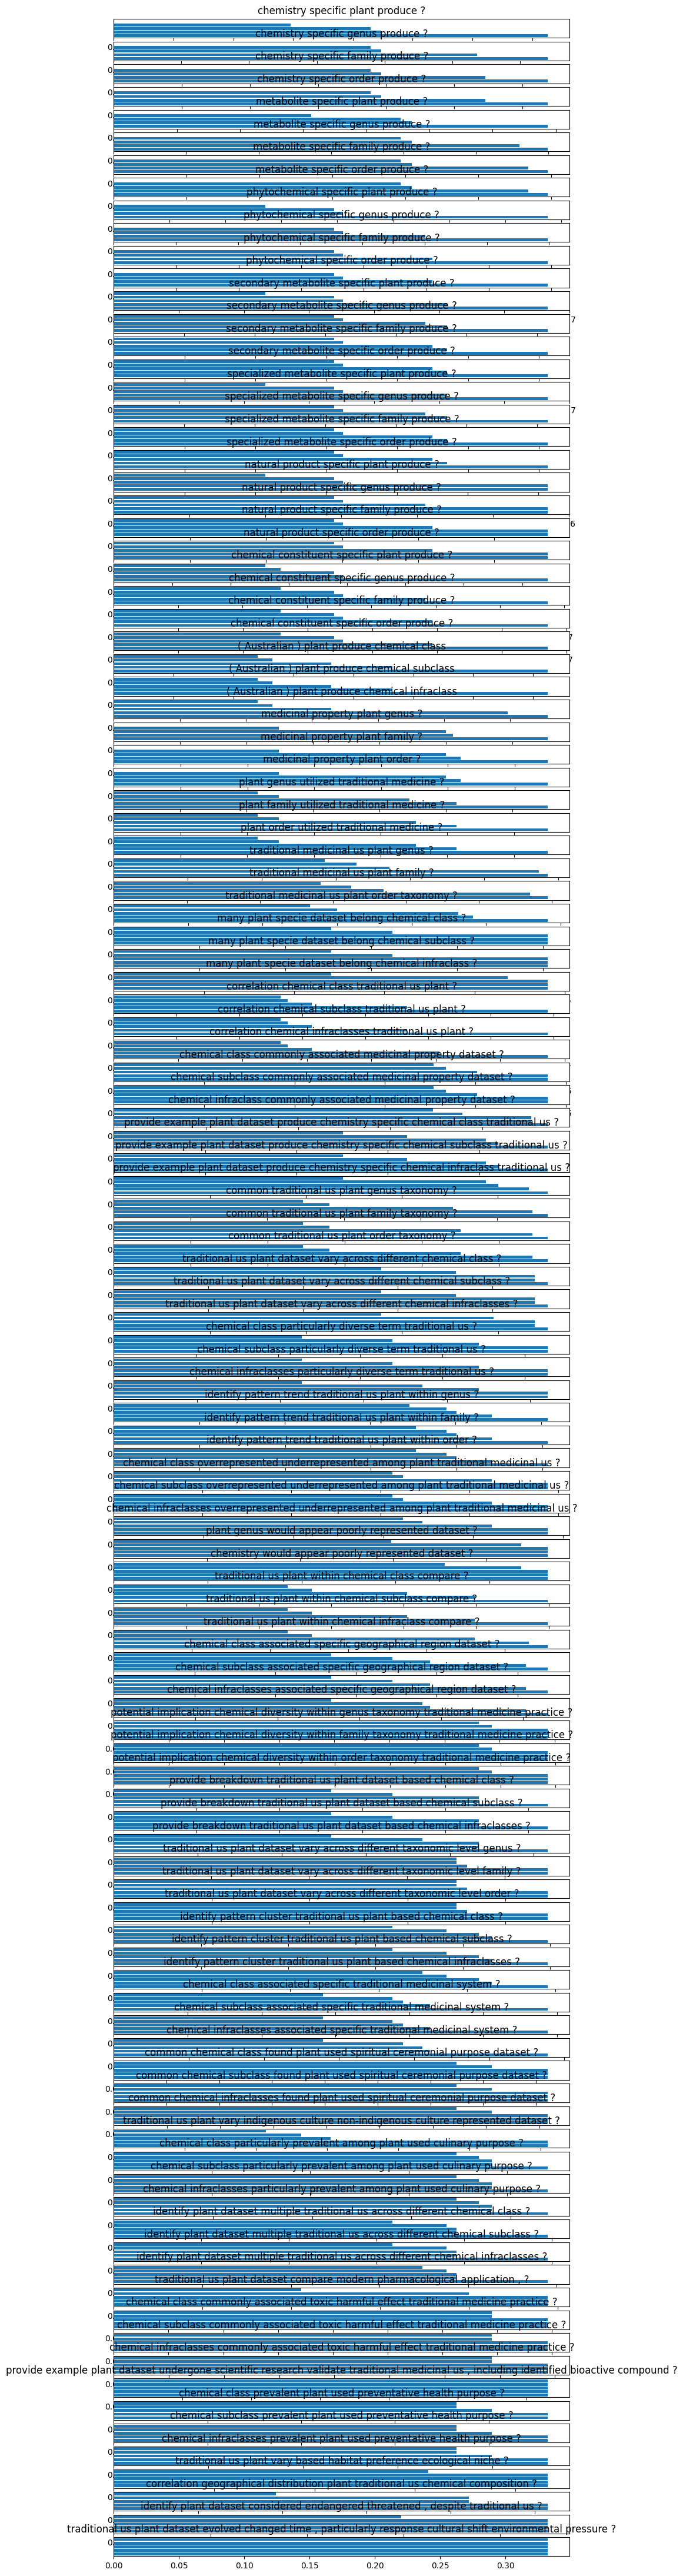

In [18]:
import numpy as np
import matplotlib.pyplot as plt

dense_matrix = tfidf_matrix.toarray()
if dense_matrix.ndim == 1:
    # If it's 1-dimensional (single question), reshape it
    dense_matrix = dense_matrix.reshape(1, -1)

top_indices=np.argsort(dense_matrix, axis=1)[:, -5:][:, ::-1]

top_words=[[feature_names[i] for i in indices] for indices in top_indices]

plt.figure(figsize=(10, len(df)*0.5))
for i, question in enumerate(df.get('Questions')):
    plt.subplot(len(df), 1, i+1)
    plt.barh(top_words[i], dense_matrix[i, top_indices[i]])
    plt.title(question)
    plt.yticks([])
plt.tight_layout()
plt.show()

## Dimensionality reduction and scatter plots

Visualize clusters or relationships between questions in a lower-dimensional space.

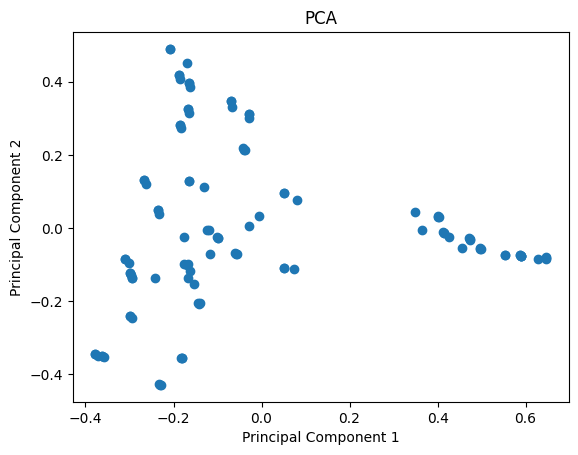

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 3 dimensions using PCA
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

# Create a scatter plot
plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.show()

# Dimensionality reduction

* PCA
* t-SNE

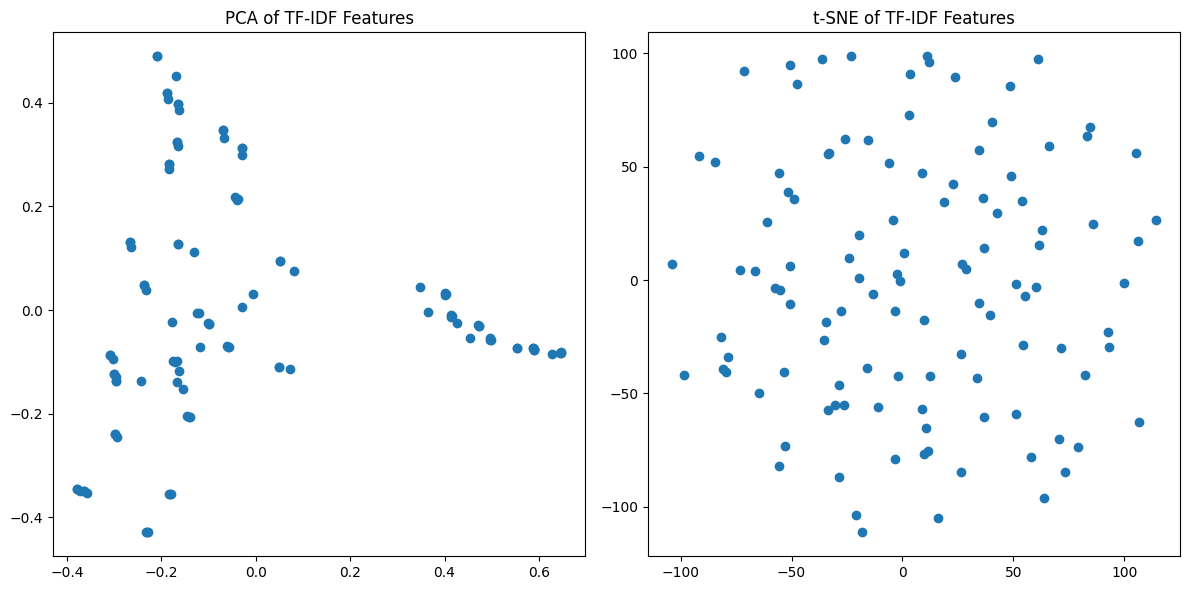

In [20]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# PCA
pca = PCA(n_components=3)  # Reduce to 3 dimensions
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# t-SNE
tsne = TSNE(n_components=3, random_state=42)  # Reduce to 3 dimensions
tsne_result = tsne.fit_transform(tfidf_matrix.toarray())

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA of TF-IDF Features')

plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE of TF-IDF Features')

plt.tight_layout()
plt.show()

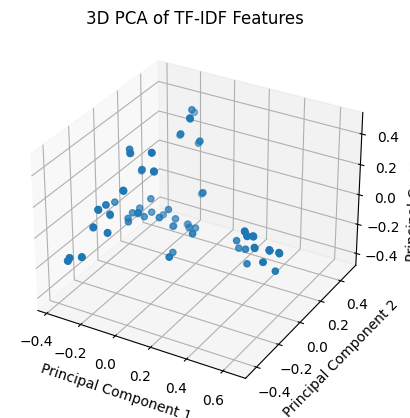

In [21]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)  # Reduce to 3 dimensions
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# 3D Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of TF-IDF Features')

plt.show()

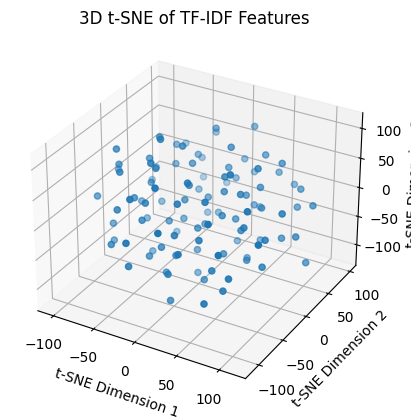

In [22]:
# t-SNE
tsne = TSNE(n_components=3, random_state=42)  # Reduce to 3 dimensions
tsne_result = tsne.fit_transform(tfidf_matrix.toarray())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2])
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
ax.set_title('3D t-SNE of TF-IDF Features')

plt.show()

# Clustering algorithms

* K-Means
* Hierarchical Clustering
* DBSCAN(Density-Based Spatial Clustering of Application with Noise)

In [23]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score


# K-Means Clustering
kmeans = KMeans(n_clusters=3)  # Choose the number of clusters
kmeans.fit(tfidf_matrix.toarray())
kmeans_labels = kmeans.labels_


# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=3)  # Choose the number of clusters
hierarchical.fit(tfidf_matrix.toarray())
hierarchical_labels = hierarchical.labels_

# Evaluate Clustering (optional)
kmeans_silhouette = silhouette_score(tfidf_matrix.toarray(), kmeans_labels)
hierarchical_silhouette = silhouette_score(tfidf_matrix.toarray(), hierarchical_labels)

print("K-Means Silhouette Score:", kmeans_silhouette)
print("Hierarchical Clustering Silhouette Score:", hierarchical_silhouette)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means Silhouette Score: 0.09538331045753269
Hierarchical Clustering Silhouette Score: 0.10196427787387481


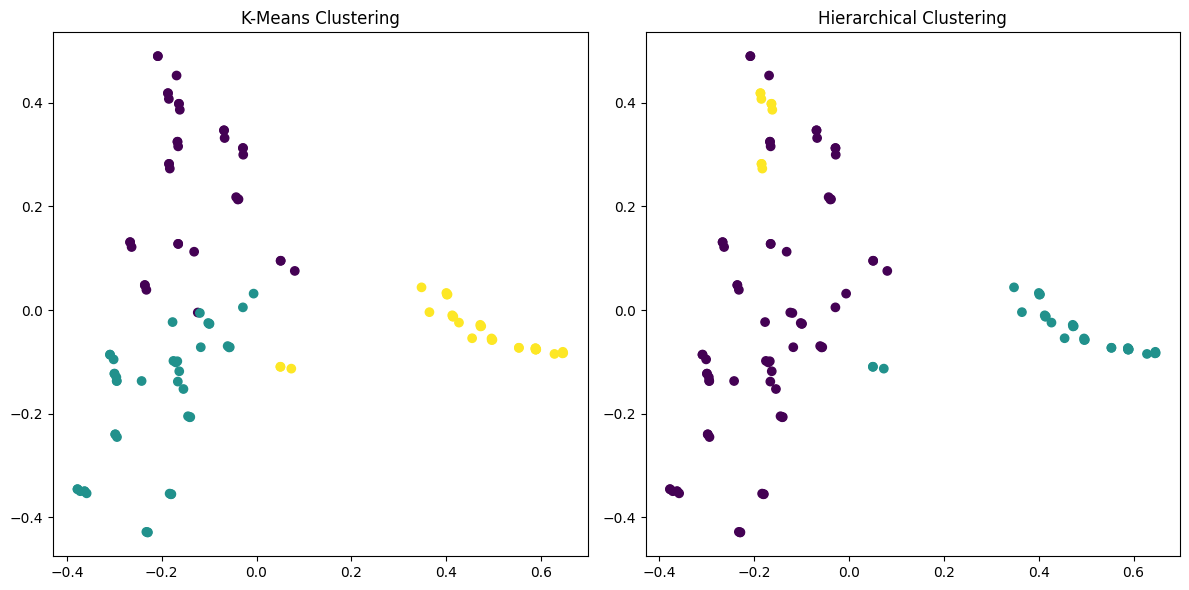

In [24]:
# PCA for visualization
pca = PCA(n_components=3)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels)
plt.title('K-Means Clustering')

plt.subplot(1, 2, 2)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=hierarchical_labels)
plt.title('Hierarchical Clustering')

plt.tight_layout()
plt.show()

In [25]:
import plotly.express as px

# PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Create a DataFrame for Plotly
df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

# Create an interactive 3D scatter plot
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3')
fig.show()